In [1]:
from PIL import Image
import numpy as np
from CaptionGenerator import CaptionGenerator
import os
import dotenv
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch 


print("Loading caption generator")
dotenv.load_dotenv(".env", override=True)
openai_key =  os.getenv("OPENAI_API_KEY")
device = 'cuda:0'

cg = CaptionGenerator(openai_key, device, verbose=True, filter=False, topk=50, gpt4=True)


/home/andre/anaconda3/envs/caption/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading caption generator
CaptionGenerator VERBOSE
Filtering TRUE
Topk 50
Device cuda:0
Using GPT4
cuda:0
cuda:0


In [3]:
with open('img_paths.txt', 'r') as f: 
    img_paths = f.readlines()
    img_paths = [x.strip() for x in img_paths]
# np.random.shuffle(img_paths)
img_paths = img_paths


def get_img(img_path):
    image = Image.open(img_path)
    image = image.resize((512, 512))
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    return image


In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/andre/autocaptioning-modelception/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

def load_sa():
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    return predictor

predictor = load_sa()

In [6]:
from diffusers import StableDiffusionInpaintPipeline
import torch 

def load_diffusion():
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        # "runwayml/stable-diffusion-inpainting",
        "stabilityai/stable-diffusion-2-inpainting",
        revision="fp16",
        torch_dtype=torch.float16,
    ).to(device)
    return pipe

# pipe = load_diffusion()
del pipe

In [7]:
def generate_bboxes(image):
    count, bboxes, text_labels = cg.get_objects(image)
    return bboxes, text_labels, count

from PIL import ImageFont 
fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
def draw_bounding_boxes(image, bboxes, labels, captions):
    # dont draw on original image
    image = image.copy()
    draw = ImageDraw.Draw(image)
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        # write label in big font
        draw.text((x1, y1), labels[i], font=fnt, fill="yellow")
    return image

def bilinear_interpolation(x, y, q11, q12, q22, q21):
    return q11 * (1 - x) * (1 - y) + \
           q21 * x * (1 - y) + \
           q12 * (1 - x) * y + \
           q22 * x * y



In [8]:
import os
import numpy as np 

parent_dir = '/home/andre/autocaptioning-modelception/images_angled'
segmentations = {}

for subdir in os.listdir(parent_dir):
    segmentations[subdir] = []
    for file in os.listdir(os.path.join(parent_dir, subdir)):
        # print(file)
        if file.endswith('_npimg.npy'):
            seg = {}
            seg['image'] = np.load(f'{parent_dir}/{subdir}/{file}')
            seg['mask'] = np.load(f'{parent_dir}/{subdir}/{file[:-10]}_mask.npy')
            seg['bbox'] = np.load(f'{parent_dir}/{subdir}/{file[:-10]}_bbox.npy')
            segmentations[subdir].append(seg)

for key in segmentations.keys():
    print(key, len(segmentations[key]))

salt 4
corn 3
pepper 4
grapes 3
empty 1
carrot 3
plate 6
bowl 3


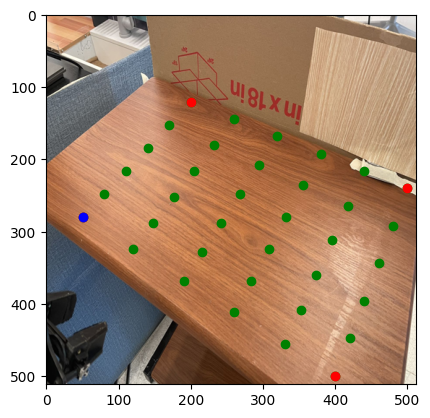

In [32]:
import matplotlib.pyplot as plt
bg = np.load('images_angled/empty/2811682031359_npimg.npy')
vertices = np.array([ [50, 280], [200, 120], [500, 240], [400, 500]])
# draw the polygon


for i in range(6):
    for j in range(6):
        u = bilinear_interpolation(i/5, j/5, *vertices)
        plt.scatter(u[0], u[1], color='green')

for v in vertices:
    plt.scatter(v[0], v[1], color='red')

u = bilinear_interpolation(0/5, 0/5, *vertices)
plt.scatter(u[0], u[1], color='blue')

plt.imshow(bg)


In [10]:
# prompt gpt4 to generate arrangements
# PROMPT = "Suppose you have a set of food items and containers. You have a plate and a bowl as containers. You also have grapes, pepper, salt, and carrot as the food items. " \
#     + "Come up with ways to arrange the items on a tabletop. You may use any number from one to four of the items or containers. " \
#     + "Describe your arrangement with words and illustrate them with a simple tikz figure, where each item is represented as a circle with a text label. Imagine that the table space is a 5 by 5 grid. Some examples: "\
#     + "1. Arrange the bowl, plate, pepper and salt into a square: "\
#     + "`\draw (1, 4) circle [radius=0.5] node{bowl}; " \
#     + "\draw (4, 4) circle [radius=0.5] node{plate}; " \
#     + "\draw (1, 1) circle [radius=0.5] node{salt}; " \
#     + "\draw (4, 1) circle [radius=0.5] node{pepper};` " \
#     + "2. Put the carrot in the bowl: "\
#     + "`\draw (2, 2) circle [radius=0.5] node{bowl}; "\
#     + "\draw (2, 2) circle [radius=0.5] node{carrot};`. "\
#     + "3. Put the grapes to the left of the bowl " \
#     + "`\draw (1, 2) circle [radius=0.5] node{grapes}; "\
#     + "\draw (4, 2) circle [radius=0.5] node{bowl};`"

# PROMPT

'Suppose you have a set of food items and containers. You have a plate and a bowl as containers. You also have grapes, pepper, salt, and carrot as the food items. Come up with ways to arrange the items on a tabletop. You may use any number from one to four of the items or containers. Describe your arrangement with words and illustrate them with a simple tikz figure, where each item is represented as a circle with a text label. Imagine that the table space is a 5 by 5 grid. Some examples: 1. Arrange the bowl, plate, pepper and salt into a square: `\\draw (1, 4) circle [radius=0.5] node{bowl}; \\draw (4, 4) circle [radius=0.5] node{plate}; \\draw (1, 1) circle [radius=0.5] node{salt}; \\draw (4, 1) circle [radius=0.5] node{pepper};` 2. Put the carrot in the bowl: `\\draw (2, 2) circle [radius=0.5] node{bowl}; \\draw (2, 2) circle [radius=0.5] node{carrot};`. 3. Put the grapes to the left of the bowl `\\draw (1, 2) circle [radius=0.5] node{grapes}; \\draw (4, 2) circle [radius=0.5] node{b

In [12]:
PROMPT = """Suppose you have a set of food items and containers. 
You have a plate and a bowl as containers. You also have grapes, pepper, salt, and carrot as the food items. 
Come up with ways to arrange the items on a tabletop. You may use any number from one to four of the items or containers. 
Describe your arrangement with words and illustrate them with a simple tikz figure, where each item is represented as a circle with a text label. 
Imagine that the table space is a 5 by 5 grid. Some examples: 
1. Arrange the bowl, plate, pepper and salt into a square: 
`\draw (1, 4) circle [radius=0.5] node{bowl};
\draw (4, 4) circle [radius=0.5] node{plate};
\draw (1, 1) circle [radius=0.5] node{salt};
\draw (4, 1) circle [radius=0.5] node{pepper};`. 
2. Put the carrot in the bowl: 
`\draw (2, 2) circle [radius=0.5] node{bowl};
\draw (2, 2) circle [radius=0.5] node{carrot};`. 
3. Put the grapes to the left of the bowl: 
`\draw (1, 2) circle [radius=0.5] node{grapes};
\draw (4, 2) circle [radius=0.5] node{bowl};`
Some extra rules: use only integer coordinates. If you want to put an item in a container, draw them 
at the same coordinate, but draw the container first. Please generate 5 different arrangements."""

import openai

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
            {"role": "system", "content": PROMPT},
        ]
    )


In [22]:
import re 
def parse_tikz_response(response: str):
    captions = re.findall(r'\d+\.\s(.*):', response)
    tikz_snippets = re.findall(r'```\n((?:\\draw .*\n)+)```', response)
    
    return list(zip(captions, tikz_snippets))

content = response['choices'][0]['message']['content']
generations = parse_tikz_response(content)

In [35]:
import re
import cv2

def get_crop(img, bbox):
    crop = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    return crop 

def paste_array(A, B, B_mask, x, y):
    """
    Paste 2D NumPy array B into another array A, centered at integer coordinates x, y.
    Handle the case where B can go over the edges of A.
    """
    A = A.copy()

    s = max(B.shape[0], B.shape[1])
    A = np.pad(A, s, mode='constant', constant_values=0)[:, :, s:-s]
    x, y = x + s, y + s

    B_mask = B_mask[:, :, np.newaxis]
    A[x-B.shape[0]//2:x+B.shape[0]//2 + B.shape[0]%2, 
        y-B.shape[1]//2:y+B.shape[1]//2 + B.shape[1] % 2] *= 1 - B_mask
    A[x-B.shape[0]//2:x+B.shape[0]//2 + B.shape[0]%2, 
        y-B.shape[1]//2:y+B.shape[1]//2 + B.shape[1] % 2] += B * B_mask
    A = A[s:-s, s:-s]

    return A

def paste_mask(A, B, x, y):
    """
    Paste 2D NumPy array B into another array A, centered at integer coordinates x, y.
    Handle the case where B can go over the edges of A.
    """
    A = A.copy()

    s = max(B.shape[0], B.shape[1])
    A = np.pad(A, s, mode='constant', constant_values=0)
    x, y = x + s, y + s

    A[x-B.shape[0]//2:x+B.shape[0]//2 + B.shape[0]%2, 
        y-B.shape[1]//2:y+B.shape[1]//2 + B.shape[1] % 2] += B
    A = A[s:-s, s:-s]
    A = np.clip(A, 0, 1)

    return A

def parse_tikz_commands(tikz_commands):
    tuples = []
    for command in tikz_commands:
        # extract the x and y coordinates
        xy = re.search(r'\((.*),(.*)\)', command)
        x = float(xy.group(1))
        y = float(xy.group(2))
        
        # extract the label
        label = re.search(r'node\{(.*?)\}', command)
        if label:
            label = label.group(1)
        else:
            # if no label is found, use the shape as the label
            shape = re.search(r'(\w+)$', command)
            label = shape.group(1)
        
        tuples.append((x, y, label))
        
    return tuples

grid_size = [6, 6]

for caption, tikz_command in generations:
    # tikz_command = """\draw (1, 1) circle [radius=0.5] node{bowl};
    # \draw (1, 1) circle [radius=0.5] node{grapes};
    # \draw (1, 5) circle [radius=0.5] node{plate};
    # \draw (1, 5) circle [radius=0.5] node{carrot};
    # \draw (4, 1) circle [radius=0.5] node{salt};
    # \draw (5, 1) circle [radius=0.5] node{pepper};
    # """
    # tikz_command = """\draw (1, 1) circle [radius=0.5] node{plate};
    # \draw (3, 3) circle [radius=0.5] node{grapes};
    # \draw (5, 5) circle [radius=0.5] node{carrot};
    # """
    # tikz_command = """\draw (2.5, 2.5) circle [radius=0.5] node{bowl};
    # \draw (1, 2.5) circle [radius=0.5] node{salt};
    # \draw (4, 2.5) circle [radius=0.5] node{pepper};
    # """
    state = parse_tikz_commands(tikz_command.split(';')[:-1])

    # state is a list of (i, j, obj_name) tuples
    # sort them by the distance to (0, 0)
    state = sorted(state, key=lambda x: -(x[0] - 0)**2 - (x[1] - 0)**2)
    # state = reversed(state)

    kernel = np.ones((3,3),np.uint8)

    inpainting_mask = np.zeros((512, 512))
    image = bg.copy()

    for i, j, obj_name in state:
        seg = np.random.choice(segmentations[obj_name])
        bbox = seg['bbox']
        mask = seg['mask'].astype(np.uint8)
        obj = seg['image']
        dilated_mask = cv2.dilate(mask, kernel, iterations=5)
        obj_edge = dilated_mask - mask
        
        mask_crop = get_crop(mask, bbox)
        obj_edge_crop = get_crop(obj_edge, bbox)
        obj_crop = get_crop(obj, bbox)

        cx, cy = bilinear_interpolation(i/grid_size[0], j/grid_size[1], *vertices)
        cx, cy = int(cx), int(cy)
        image = paste_array(image, obj_crop, mask_crop, cy, cx)

        inpainting_mask = paste_mask(inpainting_mask, obj_edge_crop, cy, cx)

    # plot img and mask side by side
    # fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    # ax[0].imshow(image)
    # ax[1].imshow(inpainting_mask)

    # convert to PIL image
    image = Image.fromarray(image)
    # save image
    image.save(f'outputs/{caption}.png')
    


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


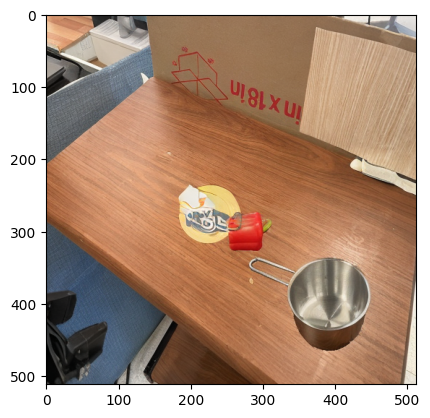

In [40]:
# pipe = load_diffusion()
output = pipe(prompt="",
            image=image,
            mask_image=inpainting_mask,).images[0]
plt.imshow(output)

In [16]:
# cg.set_words(['mechanical arm', 'bowl', 'spoon', 'knife', 'spatula', 
                # 'sink', 'plate', 'towel', 'stove', 'fork', 'pepper', 'table'])
# cg.set_words(['bowl', 'spoon', 'knife', 'spatula', 
                # 'sink', 'towel', 'stove', 'fork', 'pepper'])

# cg.set_words(['table'])
# objects = {}

# random_order = np.random.permutation(len(img_paths))
# for k in random_order[:10]:
#     img = get_img(img_paths[k])
#     bboxes, labels, count = generate_bboxes(img)

#     bimg = draw_bounding_boxes(img, bboxes, labels, None)
#     # plt.imshow(img)

#     npimg = np.array(img)
#     predictor.set_image(npimg)

#     def get_crop(img, bbox):
#         crop = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#         return crop 

#     # show images side by side
#     # fig, ax = plt.subplots(2, 5, figsize=(10, 10))
#     for i, (bbox, label) in enumerate(zip(bboxes, labels)):
#         input_box = np.array(bbox)
#         print('segmenting for ' + label)
#         masks, _, _ = predictor.predict(
#             point_coords=None,
#             point_labels=None,
#             box=input_box[None, :],
#             multimask_output=False,
#         )
#         mask = masks[0]
#         print(bbox)
#         cropped_img = get_crop(npimg, bbox)
#         cropped_mask = get_crop(masks[0], bbox)
#         segmented = cropped_img * cropped_mask[..., None]
#         print(segmented.shape)

#         if label not in objects:
#             objects[label] = []
#         objects[label].append(segmented)
#         # ax[i//5][i%5].imshow(segmented)

# # ax[1][4].imshow(bimg)
print(objects.keys())
for key in objects:
    print(len(objects[key]))
# fig, ax = plt.subplots(2, 5, figsize=(10, 10))
# for j,img in enumerate(objects['fork']):
#     ax[j//5][j%5].imshow(img)

dict_keys(['towel', 'sink', 'bowl', 'pepper', 'spatula', 'knife', 'fork', 'spoon'])
12
7
7
6
7
7
4
4


In [56]:
key = 'pepper'
i = 6

img = objects[key][i]
plt.imshow(img)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 key = 'pepper'                                                                               │
│   2 i = 6                                                                                        │
│   3                                                                                              │
│ ❱ 4 img = objects[key][i]                                                                        │
│   5 plt.imshow(img)                                                                              │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

In [40]:
np.save(f'obj_images/{key}_{i}.npy', img)

In [46]:
# good = {}
# good['bowl'] = [objects['bowl'][_] for _ in [0, 4, 6, 8]]
# good['towel'] = [objects['towel'][_] for _ in [0, 1, 2, 3, 9]]
# good['spoon'] = [objects['spoon'][_] for _ in [0, 3, 4]]

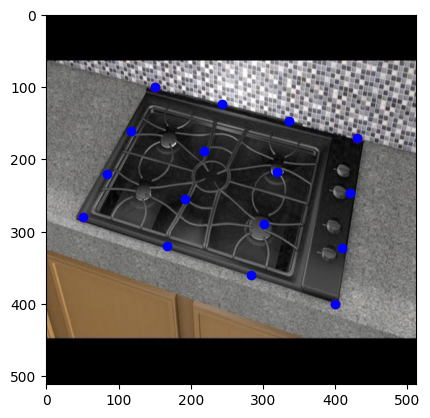

In [6]:
# k= 122
# img = get_img(img_paths[k])
img = get_img('/home/andre/autocaptioning-modelception/sddefault.jpg')
# plt.imshow(img)
bg = img
# save image
# img.save('test.png')
import numpy as np

vertices = np.array([(150, 100), (430, 170), (400, 400), (50, 280)])
# print(vertices)

plt.imshow(bg)
for v in vertices:
    plt.scatter(*v, c='r')


gd = 4j
gdr = int(gd.imag)
unit_grid = np.mgrid[0:1:gd, 0:1:gd].transpose((1, 2, 0))



# A, v0 = make_projection(vertices)
for i in range(gdr):
    for j in range(gdr):
        u = unit_grid[i, j]
        v = bilinear_interpolation(u[0], u[1], *vertices)
        plt.scatter(*v, c='b')
# u = np.array([1, 0])
# v= A @ u + v0
# plt.scatter(*v, c='b')

# v = bilinear_interpolation(0, 1, *vertices)
# plt.scatter(*v, c='b')

# us = [[0, 0], [1, 0], [1, 1], [0, 1]]
# vs = [map_point_to_quad(u[0], u[1], vertices) for u in us]
# print(vs)
# for v in vs:
#     plt.scatter(*v, c='b'


plt.show()

bg shape:  (1024, 1024, 3)
center coords:  [499 379]
obj size:  (110, 115, 3)
center coords:  [557 544]
obj size:  (26, 71, 3)
center coords:  [422 576]
obj size:  (131, 80, 3)


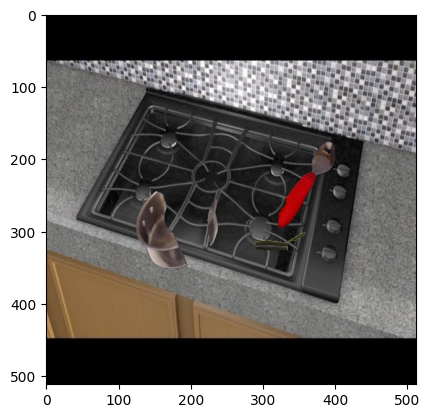

In [15]:
import cv2
def paste_obj(objects, coords, bg):
    bg = bg.copy()
    bg = np.array(bg)
    bg_ = np.zeros((1024, 1024, 3))
    bg_[256:256+bg.shape[0], 256:256+bg.shape[1]] = bg
    bg = bg_
    # plt.imshow(bg)
    print('bg shape: ', bg.shape)
    total_mask = np.zeros(bg.shape[:2], dtype=bool)
    for obj, coord in zip(objects, coords):
        coord = np.array(coord).astype(int)
        coord = coord + 256
        # print(coord)
        print('center coords: ', coord)
        print('obj size: ', obj.shape)

        obj_mask = obj.sum(axis=2) > 0
        
        bg[coord[0]:coord[0]+obj.shape[0], coord[1]:coord[1]+obj.shape[1]][obj_mask] = obj[obj_mask]
        total_mask[coord[0]:coord[0]+obj.shape[0], coord[1]:coord[1]+obj.shape[1]] = total_mask[coord[1]:coord[1]+obj.shape[0], coord[0]:coord[0]+obj.shape[1]] | obj_mask
    
    kernel = np.ones((3,3),np.uint8)
    dilated_mask = total_mask.copy()
    dilated_mask = cv2.dilate(dilated_mask.astype(np.uint8),  kernel, iterations = 15)
    inpaint_mask = dilated_mask - total_mask

    return bg[256:-256, 256:-256].astype(np.uint8), total_mask[256:-256, 256:-256], inpaint_mask[256:-256, 256:-256]

objs = [objects['bowl'][4], objects['spatula'][2], objects['spoon'][3]]
coords = np.array([(0, 1/3), (2/3, 2/3), (3/3, 1/3)])
coords = [bilinear_interpolation(u[0], u[1], *vertices) for u in coords]

nbg, tm, inpm = paste_obj(objs, coords, bg)


# dilated_mask = cv2.dilate(tm.astype(np.uint8),  kernel, iterations = 15)

# plt.imshow(nbg.astype(int))
plt.imshow(nbg)

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


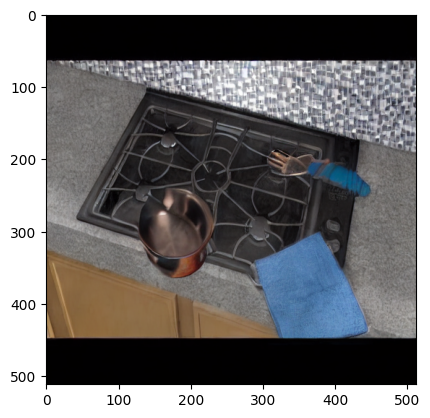

In [14]:
output = pipe(prompt="",
            image = nbg,
            mask_image = inpm).images[0]
plt.imshow(output)

100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


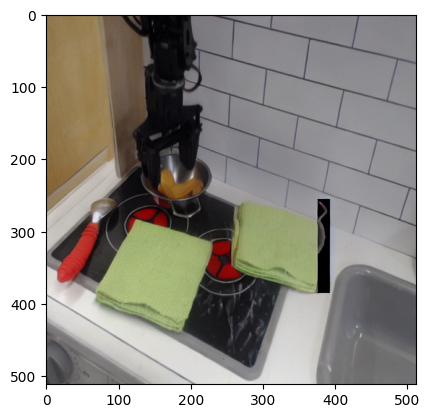

In [66]:
bg = np.array(bg)

obj = good['towel'][0]
obj_mask = (np.sum(obj, axis=2) > 0).astype(np.uint8)

kernel = np.ones((3,3),np.uint8)

# dilated_mask = cv2.dilate(obj_mask, kernel, iterations = 15)
offset = (256, 256)

bg[offset[0]:offset[0]+obj.shape[0], offset[1]:offset[1]+obj.shape[1]] = obj


inpainting_mask = np.ones_like(bg)[:, :, 0]
inpainting_mask[offset[0]:offset[0]+obj.shape[0], offset[1]:offset[1]+obj.shape[1]] = obj_mask


output = pipe(prompt="", 
            image=bg, 
            # mask_image=masks[0].astype(np.uint8),
            mask_image=1 - inpainting_mask.astype(np.uint8),
            ).images[0]
plt.imshow(output)

# plt.imshow(inpainting_mask)


In [ ]:
# pipeline
# object segmented objects from scenes
# generate initial + goal images using background + objects 

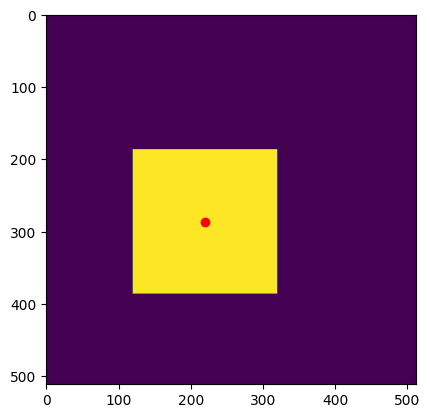

In [19]:
img = get_img('/home/andre/autocaptioning-modelception/test_images/bg.jpg')
img = np.array(img)

vertices = np.array([[170, 140], [10, 280], [300, 500], [400, 230]])

center = bilinear_interpolation(0.5, 0.5, *vertices)
center = center.astype(int)
plt.scatter(*center, c='r')

mask = np.zeros(img.shape[:2], dtype=bool)
# set a rectangle centered around center to be True
radius = 100
mask[center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius] = True

plt.imshow(mask)

100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


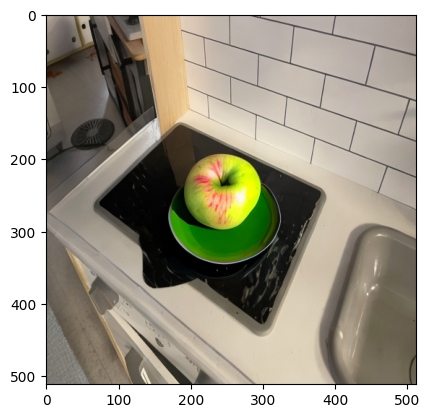

In [21]:

pipe = load_diffusion()
output = pipe(prompt="A large green plate with an apple in it, high resolution", 
            image=img, 
            # mask_image=masks[0].astype(np.uint8),
            mask_image=mask.astype(np.uint8),
            ).images[0]
plt.imshow(output)


In [7]:
del pipe

Getting objects


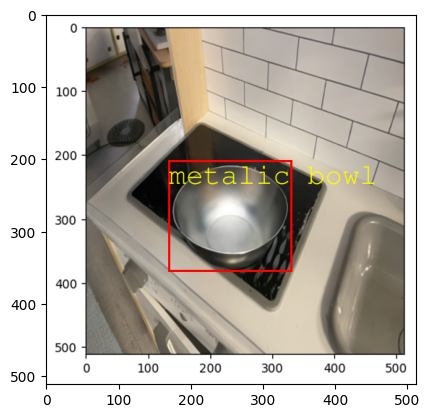

In [8]:
cg.set_words(['metalic bowl'])
img = get_img('/home/andre/autocaptioning-modelception/test_images/output.png')
bboxes, labels, count = generate_bboxes(img)
bimg = draw_bounding_boxes(img, bboxes, labels, None)

input_box = np.array(bboxes[0])
img = np.array(img)
predictor.set_image(img)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.imshow(bimg)

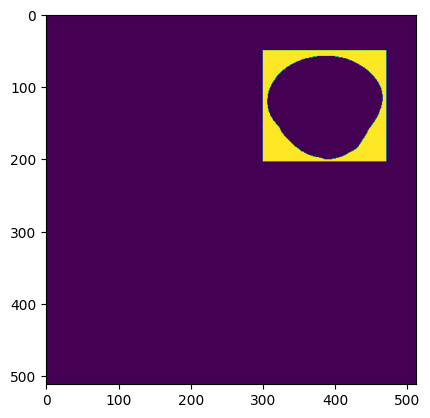

In [44]:
def get_crop(img, bbox):
    crop = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    return crop 

obj = img * masks[0][:, :, None]
obj_crop = get_crop(obj, input_box)
inpmc = (obj_crop.sum(axis=2) > 0).astype(np.uint8)
# inpainting_mask = 

# plt.imshow(inpmc)

bg = get_img('/home/andre/autocaptioning-modelception/test_images/bg.jpg')
bg = np.array(bg)

x, y = 50, 300
bg[x:x+obj_crop.shape[0], y:y+obj_crop.shape[1]] = obj_crop

inpm = np.zeros_like(bg[:, :, 0])
inpm[x:x+obj_crop.shape[0], y:y+obj_crop.shape[1]] = 1 - inpmc

plt.imshow(inpm)

100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


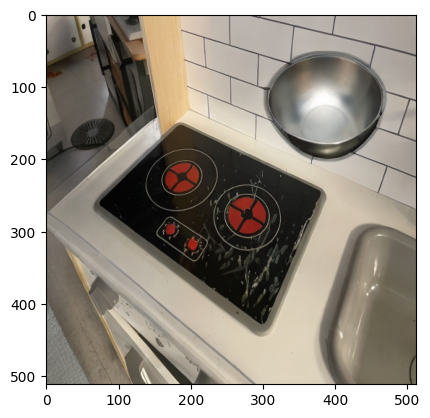

In [45]:
output = pipe(prompt="Metal bowl on the stove, high resolution",
            image=bg,
            mask_image=inpm.astype(np.uint8),).images[0]
plt.imshow(output)

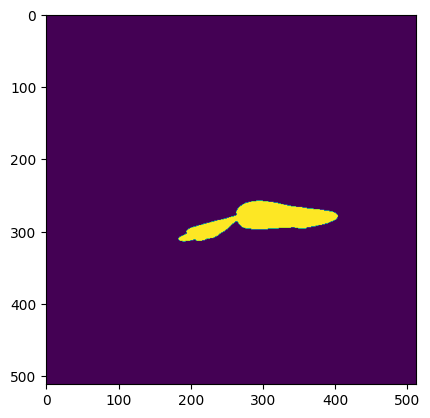

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
mask = np.load('./images/carrot3_mask.npy')
plt.imshow(mask)

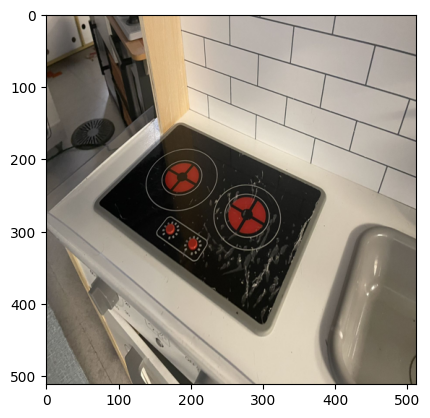

In [85]:
bg = get_img('/home/andre/autocaptioning-modelception/test_images/bg.jpg')
plt.imshow(bg)

100%|██████████| 50/50 [04:54<00:00,  5.90s/it]


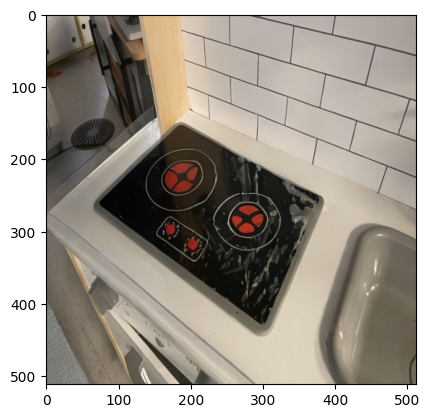

In [90]:
# plt.imshow(bg)
bg = np.array(bg)
mask = np.zeros_like(bg[:, :, 0])
mask[100:300, 200:400] = 1

# prompts= ["metallic bowl on table, top down view", "apple on table, top down view", "apple, top down view",
                        # "carrot, top down view", "apple"]

prompts = ['plate on table', 'orange on table', 'orange', 'apple on stove', 'apple']

outputs = pipe(prompt=prompts, 
            image=bg,
            num_inference_steps=50,
            mask_image=mask.astype(np.uint8),)
plt.imshow(outputs.images[0])

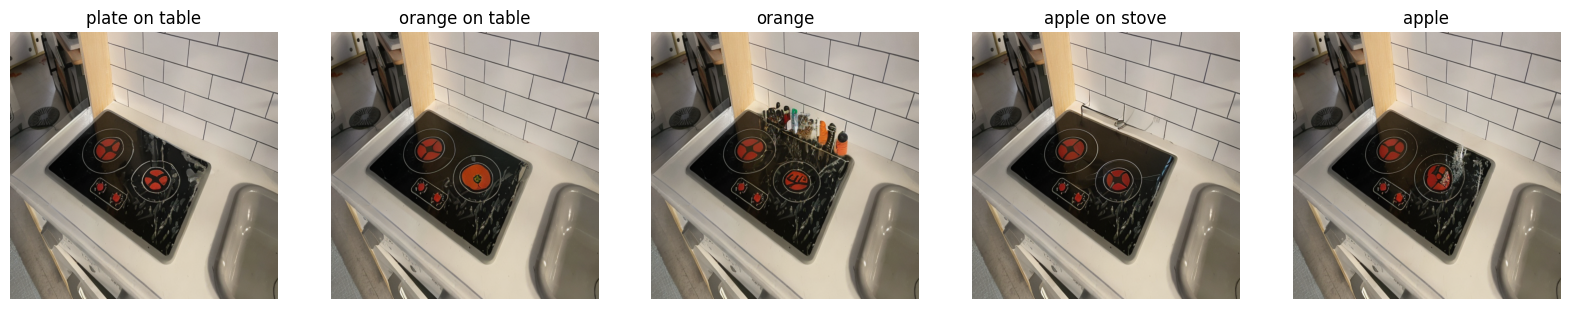

In [91]:
# show the images side by side
fig, axs = plt.subplots(1, len(outputs.images), figsize=(20, 20))
for i, ax in enumerate(axs):
    ax.imshow(outputs.images[i])
    ax.set_title(prompts[i])
    ax.axis('off')